# parse svg to get control points and length for each curve

In [1]:
from svg.path import parse_path
import xml.etree.ElementTree as ET
import numpy as np

ns = "{http://www.w3.org/2000/svg}"
tree = ET.parse("svgs/doll_dress.svg")
root = tree.getroot()

g = root.findall(ns + "g")[0]
paths = g.findall(ns  + "path")
path_objs = []

for p in paths:
    path_obj = parse_path(p.attrib["d"])
    path_objs.append(path_obj)


html_str_1 = '''
<!DOCTYPE html>
<html>
<body>

<svg height="800" width="1000">
<g transform="scale(4)">
'''

html_path_str = ""

# for p in paths:
#     html_path_str += "<path d=\"" + p.attrib["d"] + "\" />\n"
        
# [cps for curve1, cps for curve2, ...]
paths_cps = []
# [length of curve1, length of curve2, ...]
paths_lengths = []
# [[curve1_id, curve2_id, ..], [curve1_id, curve2_id, ..], ...] 
shape_curve_ids = []

c_id = 0
for p_obj in path_objs:
    path_cps = []
    path_lens = []
    curve_ids = []
    for i in range(len(p_obj)):
        curve = p_obj[i]
        p_name = type(curve).__name__
        d_str = ""
        if p_name == "CubicBezier":
            cpts = np.zeros([4, 2])
            cpts[0][0] = curve.start.real
            cpts[0][1] = -curve.start.imag
            cpts[1][0] = curve.control1.real
            cpts[1][1] = -curve.control1.imag
            cpts[2][0] = curve.control2.real
            cpts[2][1] = -curve.control2.imag
            cpts[3][0] = curve.end.real
            cpts[3][1] = -curve.end.imag
            
            d_str = d_str + "M " + str(curve.start.real) + " " + str(curve.start.imag) + " "
            d_str = d_str + "C " + str(curve.control1.real) + " " + str(curve.control1.imag)
            d_str = d_str + ", " + str(curve.control2.real) + " " + str(curve.control2.imag)
            d_str = d_str + ", " + str(curve.end.real) + " " + str(curve.end.imag)
            
            path_cps.append(cpts)
            curve_ids.append(c_id)
        elif p_name == "Line" or p_name == "Close":
            if curve.length() < 0.0001:
                continue
                
            cpts = np.zeros([2, 2])
            cpts[0][0] = curve.start.real
            cpts[0][1] = -curve.start.imag
            cpts[1][0] = curve.end.real
            cpts[1][1] = -curve.end.imag
        
            d_str = d_str + "M " + str(curve.start.real) + " " + str(curve.start.imag) + " "
            d_str = d_str + "L " + str(curve.end.real) + " " + str(curve.end.imag)
            
            path_cps.append(cpts)
            curve_ids.append(c_id)
            
        else:
            continue
            
        path_lens.append(curve.length())
        
        html_path_str += "<path id = \"" + str(c_id) + "\" d=\"" + d_str + "\" stroke=\"black\" fill=\"transparent\" />\n"
        c_id +=1
        
    shape_curve_ids.append(curve_ids)
    paths_cps.extend(path_cps)
    paths_lengths.extend(path_lens)
        
# label the paths
html_text_str = "<text font-size=\"4\">"

for i in range(len(paths_cps)):
    html_text_str = html_text_str + "<textPath href=\"#" + str(i) + "\" startOffset=\"40%\">" + str(i) + "</textPath>\n"
html_text_str += "</text>"

# end of html file
html_str_2 = '''
</g>
</svg>

</body>
</html>
'''
html_file = open("svg_display.html", "w")
html_file.write(html_str_1)
html_file.write(html_path_str)
html_file.write(html_text_str)
html_file.write(html_str_2)
html_file.close()


In [2]:
shape_ccw = [None] * len(shape_curve_ids)
for sid in range(len(shape_curve_ids)):
    cids = shape_curve_ids[sid]
    v1 = paths_cps[cids[0]][-1] - paths_cps[cids[0]][0]
    wind_num = 0
    
    def getAngle(v1, v2):
        cross_p = np.cross(v1, v2)
        cos_theta = np.dot(v1, v2);
        if cross_p > 0:
            return cos_theta
        else:
            return -cos_theta
            
    for cid in range(1, len(cids)):
        v2 = paths_cps[cids[cid]][-1] - paths_cps[cids[cid]][0]
        wind_num += getAngle(v1, v2)
        v1 = v2;

    v2 = paths_cps[cids[0]][-1] - paths_cps[cids[0]][0]
    wind_num += getAngle(v1, v2)
    
    if wind_num > 0:
        shape_ccw[sid] = True
    else:
        shape_ccw[sid] = False
print("shape_ccw: ", shape_ccw)

shape_ccw:  [False, False, False, True, True, True]


# specify pair of curves to match, if same orientation

In [3]:

# path_pairs_no_orientation = [
#     (8, 25), 
#     (22, 5), 
#     (13, 28),
#     (14, 19),
#     (30, 11),
#     (31, 2),
#     (23, 18),
#     (1, 6),
#     (27, 20),
#     (3, 10),
#     (12, 15),
#     (32, 29)
# ]

path_pairs_no_orientation = []
path_pairs = []

In [4]:
def getShapeId(cid):
    global shape_curve_ids
    for sid in range(len(shape_curve_ids)):
        if cid in shape_curve_ids[sid]:
            return sid

for ppair in path_pairs_no_orientation:
    sid1 = getShapeId(ppair[0])
    sid2 = getShapeId(ppair[1])
    ccw1 = shape_ccw[sid1]
    ccw2 = shape_ccw[sid2]  
    path_pairs.append((ppair[0], ppair[1], ccw1 != ccw2))

In [5]:

import math

path_lens = np.array(path_lens)
# at least have this many pts on one curve
min_curve_pts_num =12
# desired segment length
seg_len = np.amin(path_lens) / min_curve_pts_num

# get number of vertices for each curve
curve_vert_nums = [0] * len(paths_cps)

for pair in path_pairs:
    # use the maximum curve length of the pair of curves
    c1_len = paths_lengths[pair[0]]
    c2_len = paths_lengths[pair[1]]
    max_len = max(c1_len, c2_len)
    # ensure that each segment is less than seg_len
    c_vert_num = math.ceil( max_len / seg_len)
    # set vertices num for both curves
    curve_vert_nums[pair[0]] = c_vert_num
    curve_vert_nums[pair[1]] = c_vert_num

for cid in range(len(paths_cps)):
    # skip if already set
    if curve_vert_nums[cid] == 0:
        c_len = paths_lengths[cid]
        curve_vert_nums[cid] = math.ceil( c_len / seg_len)

bndry_verts = [None] * len(paths_cps) # all vertices!
bndry_reps = [None] * len(paths_cps)
err_thresh = 0.01
max_it = 20

def get_pair(c_id):
    global path_pairs
    for pair in path_pairs:
        if c_id == pair[0]:
            return pair[1]
        elif c_id == pair[1]:
            return pair[0]
    return -1

def getPtOnCurve(cps, t):
    return (1-t)**3 * cps[0] + 3*t*(1-t)**2 * cps[1] + 3*(1-t)*t**2 * cps[2] + t**3 * cps[3]

def getEquitDistantPtOnCurve(cps, pt_num, curve_len):
    N = 500
    prev_pt = cps[0]
    seg_lens = np.zeros(N)
    for i in range(1, N):
        t = i / N
        pt = getPtOnCurve(cps, t)
        seg_lens[i] = np.linalg.norm(pt - prev_pt)
        prev_pt = pt
    avg_seg_len = curve_len / pt_num
    bndry_pts = np.zeros([pt_num, 2])
    bndry_pts[0] = cps[0]

    last_seg = 0
    last_seg_part_len = 0
    ts = np.zeros(pt_num)

    for pt_id in range(1, pt_num):
        # find the segment up to which has avg_seg_len
        acc_len = last_seg_part_len
        for i in range(last_seg, N):
            if acc_len + seg_lens[i] < avg_seg_len:
                acc_len += seg_lens[i]
            else:
                # find the portion in segment
                last_seg_part_len = acc_len + seg_lens[i] - avg_seg_len
                last_seg = i + 1
                t = i / N - ( last_seg_part_len / seg_lens[i] ) / N
                ts[pt_id] = t
                bndry_pts[pt_id] = getPtOnCurve(cps, t)
#                 print("seg len = ", np.linalg.norm(bndry_pts[pt_id] - bndry_pts[pt_id-1]))
                break
    return bndry_pts, ts

def getTangent(cps, t):
    return 3 * (1-t)**2 * (cps[1] - cps[0]) + 6 * (1-t) * t * (cps[2] - cps[1]) + 3 * t**2 * (cps[3] - cps[2])

def getReps(cps, ts):
    reps = np.zeros([len(ts), 2])
    for i in range(len(ts)):
        tangent = getTangent(cps, ts[i])
        angle = np.arctan2(tangent[1], tangent[0])
        reps[i][0] = np.cos(angle * 4)
        reps[i][1] = np.sin(angle * 4)
    return reps

for curve_id in range(len(paths_cps)):
    curve_cps = paths_cps[curve_id]
    # number of verts on curve already calculated and stored in curve_vert_nums
    bndry_vert_num = curve_vert_nums[curve_id]
    
    # bezier curve
    if (len(curve_cps) == 4):
        curve_verts, ts = getEquitDistantPtOnCurve(curve_cps, bndry_vert_num, paths_lengths[curve_id])
        curve_reps = getReps(curve_cps, ts)
    # line
    elif (len(curve_cps) == 2):
        curve_verts = np.zeros([bndry_vert_num, 2])
        curve_reps = np.zeros([bndry_vert_num, 2])
        
        avg_seg_len = paths_lengths[curve_id] / bndry_vert_num
        d_t = 1 / bndry_vert_num
        t = 0
        dir_vec = (curve_cps[1] - curve_cps[0])
        angle = np.arctan2(dir_vec[1], dir_vec[0])
        rep = np.array([np.cos(angle * 4), np.sin(angle * 4)])
        for v_id in range(bndry_vert_num):
            pt_loc = curve_cps[0] + t * dir_vec
            curve_verts[v_id] = pt_loc
            curve_reps[v_id] = rep
            t += d_t
    
    bndry_verts[curve_id] = curve_verts
    bndry_reps[curve_id] = curve_reps

# resize the shape
size_multiplier = 1 / 16
for cid in range(len(bndry_verts)):
    for vid in range(len(bndry_verts[cid])):
        bndry_verts[cid][vid] *= size_multiplier

# how many vertices in each shape
shape_verts_num = [0] * len(path_objs)

for i in range(len(shape_curve_ids)):
    for curve_id in shape_curve_ids[i]:
        shape_verts_num[i] += len(bndry_verts[curve_id])


# shape id

In [6]:
shape_id_test = 0

In [7]:
import matplotlib.pyplot as plt

cross_len = 0.05

plt.figure(figsize=(20,20))

shape1_verts = []
shape1_reps = []

def plotCross(plt, pt, rep, color='b'):
    rep_angle = np.arctan2(rep[1], rep[0])
    angle = rep_angle / 4
    
    for i in range(2):
#         plotVec(plt, pt, angle + i * np.pi / 2)
        v = np.array([np.cos(angle + i * np.pi / 2), np.sin(angle + i * np.pi / 2)])
        v *= cross_len
        v1 = v + pt
        v2 = -v + pt
        plt.plot([pt[0], v1[0]], [pt[1], v1[1]], '-', color=color)
        plt.plot([pt[0], v2[0]], [pt[1], v2[1]], '-', color=color)
        
def plotMemCross(plt, pt, angle, color='b'):
    for i in range(2):
        v = np.array([np.cos(angle + i * np.pi / 2), np.sin(angle + i * np.pi / 2)])
        v *= cross_len
        v1 = v + pt
        v2 = -v + pt
        plt.plot([pt[0], v1[0]], [pt[1], v1[1]], '-', color=color)
        plt.plot([pt[0], v2[0]], [pt[1], v2[1]], '-', color=color)

def plotVec(plt, pt, angle, length=cross_len, color='b'):
    v = np.array([np.cos(angle), np.sin(angle)])
    v *= cross_len
    v += pt
    plt.plot([pt[0], v[0]], [pt[1], v[1]], '-', color=color)
    
for cid in shape_curve_ids[shape_id_test]:
    for i in range(len(bndry_verts[cid])):
        shape1_verts.append(bndry_verts[cid][i])
        shape1_reps.append(bndry_reps[cid][i])
        plotCross(plt, bndry_verts[cid][i], bndry_reps[cid][i])
        
plt.axis('scaled')
# plt.plot(bndry_verts[0][:,0], bndry_verts[0][:,1], 'o')

(9.402085573576628,
 11.772851929397508,
 -11.087286895567606,
 -5.670222534004477)

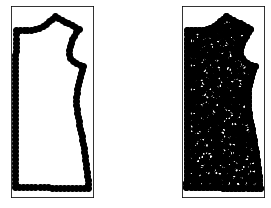

In [8]:
import matplotlib.pyplot as plt
import numpy as np

import triangle as tr

segments = []
for i in range(len(shape1_verts)-1):
    segments.append([i, i+1])
segments.append([len(shape1_verts)-1, 0])

A = dict(vertices=shape1_verts, segments=segments)
# B = tr.triangulate(A, 'pqa.05')
B = tr.triangulate(A, 'pqa.02')
tr.compare(plt, A, B)
plt.show()

In [9]:
len(shape1_verts)

118

In [10]:
faces = B['triangles']
vertices = B['vertices']
bndry_n = len(shape1_verts)
N = len(B['vertices'])

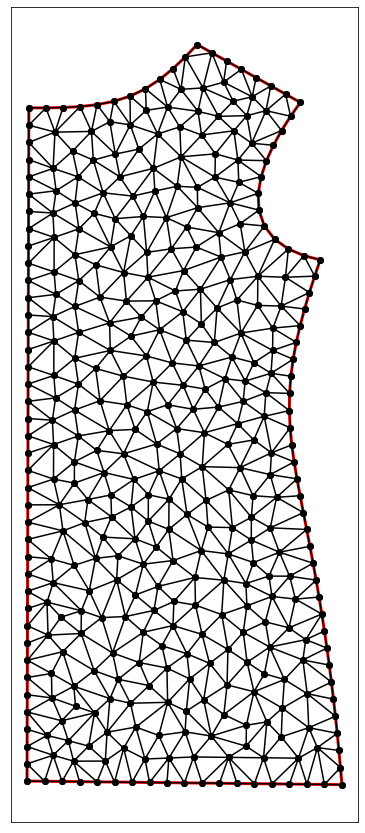

In [11]:
plt.figure(figsize=(15, 15))

tr.plot(plt.axes(), **B)

In [12]:
import harmonic_mapping

Fs = harmonic_mapping.map(faces, vertices, np.array(shape1_reps)[:,0])
Gs = harmonic_mapping.map(faces, vertices, np.array(shape1_reps)[:,1])
rep_vs = np.stack((Fs, Gs)).T
mem_as = [None]*len(rep_vs)

In [13]:
for i in range(len(rep_vs)):
    rep_angle = np.arctan2(rep_vs[i][1], rep_vs[i][0])
    angle = rep_angle / 4
    mem_as[i] = angle

In [14]:
class Singularity:
    def __init__(self, loc, vs, fgs, fid):
        self.loc = loc
        self.vs = vs
        self.bs = np.zeros(3)
        self.cs = np.zeros(3)
        
        self.bs[0] = vs[1][1] - vs[2][1]
        self.bs[1] = vs[2][1] - vs[0][1]
        self.bs[2] = vs[0][1] - vs[1][1]
        
        self.cs[0] = vs[2][0] - vs[1][0]
        self.cs[1] = vs[0][0] - vs[2][0]
        self.cs[2] = vs[1][0] - vs[0][0]
        
        self.twoA = np.dot(vs[:,0], self.bs)
        
        fs = fgs[:,0]
        gs = fgs[:,1]
        
        self.fid = fid
        
        self.fx = np.dot(fs, self.bs) / self.twoA
        self.fy = np.dot(fs, self.cs) / self.twoA
        self.gx = np.dot(gs, self.bs) / self.twoA
        self.gy = np.dot(gs, self.cs) / self.twoA
        
    def __repr__(self):
#         return "self.bs: " + str(self.bs) + ", self.cs: " + str(self.cs)
        return "fx: " + str(self.fx) + ", fy:" + str(self.fy) + ", gx:" + str(self.gx) + ", gy:" + str(self.gy)
        
    def fun(self, x):
#         return np.sin(4*x)/np.cos(4*x) - (self.gx*np.cos(x)+self.gy*np.sin(x))/(self.fx*np.cos(x)+self.fy*np.sin(x))
        return (4*np.sin(x)*np.cos(x)**3-4*np.sin(x)**3*np.cos(x)) / (np.sin(x)**4+np.cos(x)**4-6*np.sin(x)**2*np.cos(x)**2) - (self.gx*np.cos(x)+self.gy*np.sin(x))/(self.fx*np.cos(x)+self.fy*np.sin(x))

    def find_sep_angles(self):
        guesses = np.linspace(0, 2 * np.pi, num=100, endpoint=False)
        sols = opt.fsolve(self.fun, guesses, xtol=1e-12)
        prc_sols = np.sort(np.unique(sols.round(decimals=8)))
        prc_sols_2 = []
        
        print("prc_sols: ", prc_sols)
        for x in prc_sols:
            if x < 0 or x > 2 * np.pi:
                continue
            left_angle = np.arctan2(np.sin(4*x), np.cos(4*x))
            right_angle = np.arctan2((self.gx*np.cos(x)+self.gy*np.sin(x)), (self.fx*np.cos(x)+self.fy*np.sin(x)))
            if round(left_angle, 4) == round(right_angle, 4):
                prc_sols_2.append(x)
            else:
                print("left_angle: ", left_angle, "right_angle: ", right_angle)

        print("prc_sols_2: ", prc_sols_2)

        
#             for i in [1, 3]:
#                 prc_sols[i] -= np.pi
#         elif first_sol < 0:
#             guesses = np.linspace(-np.pi, 0, num=10, endpoint=False)
#             sols = opt.fsolve(self.fun, guesses, xtol=1e-14)
#             prc_sols = np.sort(np.unique(sols.round(decimals=8)))
#             prc_sols = prc_sols[len(prc_sols)-5:len(prc_sols)]
            
#             for i in [0, 2, 4]:
#                 prc_sols[i] += np.pi   
                
        self.angles = prc_sols_2
#         print("self.angles: ", self.angles)
#         for a in self.angles:
#             print("diff: ", self.fun(a))

        

In [15]:
import scipy.optimize as opt

singularities = []

for fid in range(len(faces)):
    face = faces[fid]
    vs = vertices[face]
    fgs = rep_vs[face]
    M = np.array([[fgs[0][0] - fgs[2][0], fgs[1][0] - fgs[2][0]], [fgs[0][1] - fgs[2][1], fgs[1][1] - fgs[2][1]]])
    if np.linalg.matrix_rank(M) < 2:
        continue
    rhs = np.array([-fgs[2][0], -fgs[2][1]])
    sing_coords = np.linalg.solve(M, rhs)
    if 0 <= sing_coords[0] <= 1 and 0 <= sing_coords[1] <= 1 and 0 <= sing_coords[0] + sing_coords[1] <= 1:
        sing_pos = sing_coords[0] * vs[0] + sing_coords[1] * vs[1] + (1 - sing_coords[0] - sing_coords[1]) * vs[2]
        sing = Singularity(sing_pos, vs, fgs, fid)
#         print("sing: ", sing)
        sing.find_sep_angles()
        singularities.append(sing)

# for a in singularities[0].angles:
#     print("diff: ", singularities[0].fun(a))
# print("singularities[0].angles: ", singularities[0].angles)

# for a in singularities[1].angles:
#     print("diff: ", singularities[1].fun(a))
# print("singularities[1].angles: ", singularities[0].angles)


prc_sols:  [-0.55463467  0.12543502  0.65614751  1.18854783  1.86954572  2.58695799
  3.26702767  3.79774017  4.33014049  5.01113837  5.72855064  6.40862032]
left_angle:  0.50174008 right_angle:  -2.639852594803625
left_angle:  -1.5289939871795861 right_angle:  1.612598689451407
left_angle:  -2.2185386543591723 right_angle:  0.923053977598828
left_angle:  2.624590065640827 right_angle:  -0.5170026060893614
left_angle:  1.1949975584612418 right_angle:  -1.9465950763118356
prc_sols_2:  [0.65614751, 1.86954572, 3.26702767, 4.33014049, 5.72855064]
prc_sols:  [0.28557572 0.92210641 1.52998782 2.13837443 2.77555703 3.42716838
 4.06369907 4.67158048 5.27996709 5.91714969 6.56876103]
left_angle:  1.14230288 right_angle:  -1.9992897542515347
left_angle:  -0.16323402717958602 right_angle:  2.9783586374568736
left_angle:  -1.4641424943591734 right_angle:  1.6774501776984458
left_angle:  -2.594759641538759 right_angle:  0.5468329947361407
left_angle:  2.270312438461242 right_angle:  -0.87128023308

In [16]:
class BoundaryNode:
    def __init__(self, loc, v_before):
        self.loc = loc
        self.v_before = v_before

In [17]:

dt_reg = 0.01
dt_init = 0.01
bndry_nodes = []

def segIntrsct(s1, e1, s2, e2):
    v1 = e1 - s1
    v2 = e2 - s2
    M = np.zeros([2,2])
    M[:,0] = v1
    M[:,1] = -v2
    rhs = s2 - s1
    ts = np.linalg.solve(M, rhs)
#     print("ts: ", ts)
    if ts[0] >= 0 and ts[0] <= 1 and ts[1] >= 0 and ts[1] <= 1:
        return (True, s1 + v1 * ts[0])
    return (False, None)

def getBaryCoords(v, vs):
    M = np.zeros([2,2])
    M[0] = vs[0] - vs[2]
    M[1] = vs[1] - vs[2]
    rhs = v - vs[2]
    bary_coords = np.linalg.solve(M.T, rhs)
    bary_coords = np.append(bary_coords, 1-bary_coords[0]-bary_coords[1])
    return bary_coords
        
def inRange(coords):
    res = True
    for i in range(3):
        res = res and (coords[i] >= 0 and coords[i] <=1)
    return res

def findFace(v):
    global faces, vertices
    
    for fid in range(len(faces)):
        vs = vertices[faces[fid]]
        bary_coords = getBaryCoords(v, vs)
        
        if inRange(bary_coords):
            return (fid, bary_coords)
    return None

stream_lines = []

def getClosestArm(rep, v_angle):
    rep_angle = np.arctan2(rep[1], rep[0])
    start_angle = rep_angle / 4
#     v_angle = np.arctan2(v[1], v[0])
    v_angle = ( v_angle + 2 * np.pi ) % ( 2 * np.pi )
    min_diff = np.inf
    min_arm_angle = 0
    
    for i in range(4):
        arm_angle = ( start_angle + i * np.pi / 2 + 2 * np.pi ) % ( 2 * np.pi )
        diff = min( abs(arm_angle - v_angle), 2 * np.pi - abs(arm_angle - v_angle) )
        if diff < min_diff:
            min_diff = diff
            min_arm_angle = arm_angle
            
    return min_arm_angle

def getClosestEdge(coords, fid):
    global faces, vertices
    smallest_dim = np.argmin(coords)
    
#     print("coords: ", coords)
#     print("face: ", faces[fid])
    if smallest_dim == 0:
        edge_vids = [1, 2]
    elif smallest_dim == 1:
        edge_vids = [0, 2]
    else:
        edge_vids = [0, 1]
    return faces[fid][edge_vids]
    
def traceSeparatrix(src_sing, angle_id):
    global dt_reg, dt_init, stream_lines, vertices, faces
    
    def createBndryNode(v, fid, stream_line):
        edge = getClosestEdge(getBaryCoords(stream_line[-1], vertices[faces[fid]]), fid)
        edge_vs = vertices[edge]
        bndry_node_loc = segIntrsct(stream_line[-1], v, edge_vs[0], edge_vs[1])[1]
        
        # maybe into another triangle?
        if type(bndry_node_loc) is not np.ndarray:
            # get v on bndry:
            vid_on_bndry = min(faces[fid])
            bndry_node_loc = segIntrsct(stream_line[-1], v, vertices[vid_on_bndry], vertices[vid_on_bndry+1])[1]
            stream_line.append(bndry_node_loc)
            bndry_node = BoundaryNode(bndry_node_loc, vid_on_bndry)
            bndry_nodes.append(bndry_node)
            return
            
        stream_line.append(bndry_node_loc)
        bndry_node = BoundaryNode(bndry_node_loc, min(edge))
        bndry_nodes.append(bndry_node)
                        
    stream_line = []
    stream_line.append(src_sing.loc)

    v = src_sing.loc + dt_init * np.array([np.cos(src_sing.angles[angle_id]), np.sin(src_sing.angles[angle_id])])
    res = findFace(v)
    fid = res[0]
    coords = res[1]
    stream_dir = np.array([np.cos(src_sing.angles[angle_id]), np.sin(src_sing.angles[angle_id])])
    arm_angle = src_sing.angles[angle_id]
    
    dt = dt_init
    while True:
        # stop if meeting another singularity
        met_sing = False
        for sing in singularities:
            if sing == src_sing:
                continue
            if fid == sing.fid:
                stream_line.append(v)
                stream_line.append(sing.loc)
                met_sing = True
                break
        if met_sing:
            break
        
                
        face = faces[fid]
        stream_line.append(v)

        fgs = np.array(rep_vs[face])
        fg = coords[0] * fgs[0] + coords[1] * fgs[1] + coords[2] * fgs[2]
        fg_norm = np.linalg.norm(fg)
            
        arm_angle = getClosestArm(fg, arm_angle)
        arm_v = np.array([np.cos(arm_angle), np.sin(arm_angle)]) * fg_norm

        v = v + dt * arm_v
        
        test_coords = getBaryCoords(v, vertices[face])
        if inRange(test_coords):
            coords = test_coords
            continue
        else:
            dt = dt_reg
            res = findFace(v)
            if res == None:
                createBndryNode(v, fid, stream_line)
                break
            fid = res[0]
            coords = res[1]

    stream_line = np.array(stream_line)
    stream_lines.append(stream_line)

for sing in singularities:
# sing = singularities[0]
    for a_id in range(len(sing.angles)):
        traceSeparatrix(sing, a_id)


In [18]:
len(stream_lines)

10

In [19]:
corners = []

def getCorners():
    global corners
    cnt = 0
    for i in range(len(shape_curve_ids[shape_id_test])):
        corners.append(cnt)
        cid = shape_curve_ids[shape_id_test][i]
        cnt += len(bndry_verts[cid])
        
getCorners()
corner_vs = vertices[corners]

In [20]:
bndry_nodes.sort(key=lambda x: x.v_before)
bndry_stream_lines = []
    
for i in range(len(bndry_nodes)):
    stream_line_1 = [bndry_nodes[i].loc]
    stream_line_2 = []
    start_vid = bndry_nodes[i].v_before + 1
    stop_vid = bndry_nodes[(i+1)%len(bndry_nodes)].v_before+1
    stop_mid = False
    
    if stop_vid < start_vid:
        stop_vid += len(shape1_verts)
        
    # check if stream line contain corners
    for c in corners:
        if bndry_nodes[(i+1)%len(bndry_nodes)].v_before+1 < start_vid:
            if ( start_vid < c + len(shape1_verts) and c + len(shape1_verts) < stop_vid ):
                stop_mid = True
                mid = c + len(shape1_verts)
        if start_vid < c and c < stop_vid:
            stop_mid = True
            mid = c
      
    if stop_mid:
        for j in range(start_vid, mid+1):
            stream_line_1.append(shape1_verts[j % len(shape1_verts)])
        stream_line_1 = np.array(stream_line_1)
        bndry_stream_lines.append(stream_line_1)
        
        for j in range(mid, stop_vid):
            stream_line_2.append(shape1_verts[j % len(shape1_verts)])
            
        stream_line_2.append(bndry_nodes[(i+1)%len(bndry_nodes)].loc)
        stream_line_2 = np.array(stream_line_2)
        bndry_stream_lines.append(stream_line_2)

    else:
        for j in range(start_vid, stop_vid):
            stream_line_1.append(shape1_verts[j % len(shape1_verts)])
        stream_line_1.append(bndry_nodes[(i+1)%len(bndry_nodes)].loc)
        stream_line_1 = np.array(stream_line_1)
        bndry_stream_lines.append(stream_line_1)
        

        

In [21]:
if shape_id_test == 2:
    bndry_stream_lines = [None] * 4
    print("shape_curve_ids[shape_id_test]: ", shape_curve_ids[shape_id_test])
    bndry_stream_lines[0] = bndry_verts[12]
    bndry_stream_lines[0] = np.append(bndry_stream_lines[0], [bndry_verts[13][0]], axis = 0)
    bndry_stream_lines[1] = np.append(bndry_verts[13], bndry_verts[14], axis = 0)
    bndry_stream_lines[1] = np.append(bndry_stream_lines[1], [bndry_verts[15][0]], axis = 0)
    bndry_stream_lines[2] = bndry_verts[15]
    bndry_stream_lines[2] = np.append(bndry_stream_lines[2], [bndry_verts[16][0]], axis = 0)
    bndry_stream_lines[3] = bndry_verts[16]
    bndry_stream_lines[3] = np.append(bndry_stream_lines[3], [bndry_verts[12][0]], axis = 0)

In [22]:
bndry_stream_lines

[array([[10.36325513, -6.22897179],
        [10.42601871, -6.18800738],
        [10.51234504, -6.11749443],
        [10.59316624, -6.04070236],
        [10.6701525 , -5.96005194]]), array([[10.6701525 , -5.96005194],
        [10.76633393, -6.01404845],
        [10.86251536, -6.06804496],
        [10.89617829, -6.08694342]]), array([[10.89617829, -6.08694342],
        [10.95869679, -6.12204146],
        [11.05487821, -6.17603797],
        [11.15105964, -6.23003448],
        [11.21024166, -6.26325942]]), array([[11.21024166, -6.26325942],
        [11.24724107, -6.28403099],
        [11.3434225 , -6.3380275 ]]), array([[11.3434225 , -6.3380275 ],
        [11.28009224, -6.42817871],
        [11.22117124, -6.52126263],
        [11.16796797, -6.61772231],
        [11.12246294, -6.71802477],
        [11.10842311, -6.7603043 ]]), array([[11.10842311, -6.7603043 ],
        [11.08776177, -6.82252387],
        [11.06884023, -6.93092156],
        [11.07317357, -7.04072523],
        [11.10870205, -

(9.457085218750002, 11.71785540625, -11.032610403124998, -5.718501534374999)

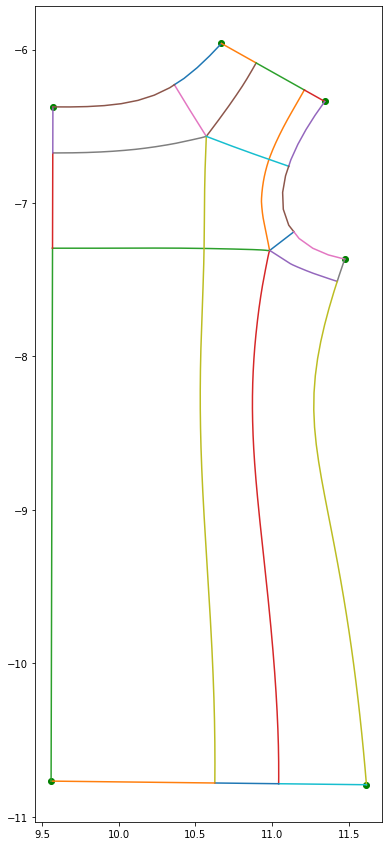

In [23]:
plt.figure(figsize=(15, 15))

# tr.plot(plt.axes(), **B)
# colormap = plt.cm.Set1
# colors = [colormap(i) for i in np.linspace(0, 1, 40)]
# plt.gca().set_prop_cycle('color', colors)

for stream_line in stream_lines:
#     print("stream_line: ", stream_line)
    plt.plot(stream_line[:,0], stream_line[:,1])
    
    
plt.plot(corner_vs[:,0], corner_vs[:,1], 'o', color='g')
# vs = vertices[[3, 59]]
# plt.plot(vs[:,0], vs[:,1], 'o', color='g')

for stream_line in bndry_stream_lines:
    plt.plot(stream_line[:,0], stream_line[:,1]) 

# tr.plot(plt.axes(), **B)

# plt.plot([1.76294323], [-7.17113539], 'o', color = 'b')


plt.axis('scaled')

(9.402085573576628,
 11.772851929397508,
 -11.087286895567606,
 -5.670222534004477)

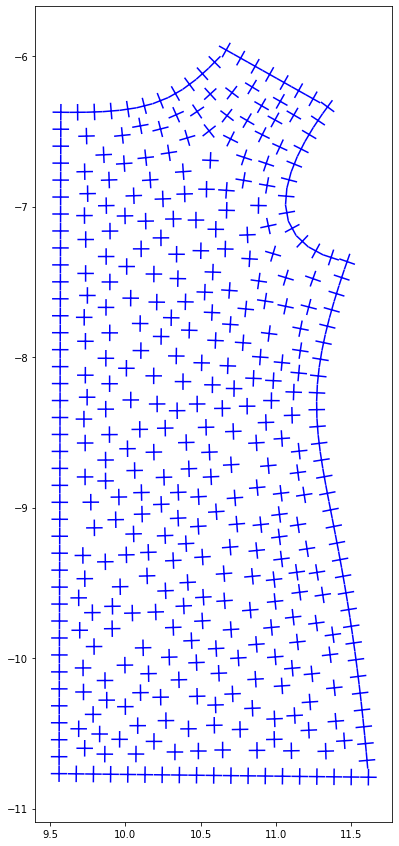

In [24]:
plt.figure(figsize=(15, 15))
    
for vid in range(N):
    plotMemCross(plt, vertices[vid], mem_as[vid])

# for stream_line in stream_lines:
#     plt.plot(stream_line[:,0], stream_line[:,1])
    
# for sing in singularities:
#     plt.plot(sing.loc[0], sing.loc[1], 'o', color='r')
#     for i in range(len(sing.angles)):
#         plotVec(plt, sing.loc, sing.angles[i], length=0.5, color='r')
        

#     tr.plot(plt.axes(), **B)
plt.axis('scaled')

In [25]:
display_intrsctns = []

def streamLineIntrsctDumb(sid1, sid2):
    global stream_lines
    v_num_1 = len(stream_lines[sid1])
    v_num_2 = len(stream_lines[sid2])
    print("v_num_1: ", v_num_1)
    print("v_num_2: ", v_num_2)
    
    for i in range(v_num_1 - 1):
        for j in range(v_num_2 - 1):
            res = segIntrsct(stream_lines[sid1][i], stream_lines[sid1][i+1], stream_lines[sid2][j], stream_lines[sid2][j+1])
            if res[0]:
                print(res[1])
                end1 = i + 1
                end2 = j + 1
                intrsctn = res[1]
                display_intrsctns.append(intrsctn)
        
                new_stream_line_1 = stream_lines[sid1][end1:v_num_1]
                new_stream_line_2 = stream_lines[sid2][end2:v_num_2]
                stream_lines[sid1] = stream_lines[sid1][:end1]
                stream_lines[sid2] = stream_lines[sid2][:end2]

                new_stream_line_1 = np.insert(new_stream_line_1, 0, intrsctn, axis=0)
                new_stream_line_2 = np.insert(new_stream_line_2, 0, intrsctn, axis=0)
                stream_lines[sid1] = np.append(stream_lines[sid1], [intrsctn], axis=0)
                stream_lines[sid2] = np.append(stream_lines[sid2], [intrsctn], axis=0)

                stream_lines.append(new_stream_line_1)
                stream_lines.append(new_stream_line_2)
                return
                
def streamLineIntrsct(sid1, sid2):
    global stream_lines
    v_num_1 = len(stream_lines[sid1])
    v_num_2 = len(stream_lines[sid2])
    res = streamLineIntrsctRec(sid1, sid2, 0, v_num_1-1, 0, v_num_2-1)
    if res != None:
        (start1, end1, start2, end2, intrsctn) = res
        if start1==0 or start2==0:
            return
        print("intrsctn: ", intrsctn)
        display_intrsctns.append(intrsctn)
        
        new_stream_line_1 = stream_lines[sid1][end1:v_num_1]
        new_stream_line_2 = stream_lines[sid2][end2:v_num_2]
        stream_lines[sid1] = stream_lines[sid1][:end1]
        stream_lines[sid2] = stream_lines[sid2][:end2]
        
        new_stream_line_1 = np.insert(new_stream_line_1, 0, intrsctn, axis=0)
        new_stream_line_2 = np.insert(new_stream_line_2, 0, intrsctn, axis=0)
        stream_lines[sid1] = np.append(stream_lines[sid1], [intrsctn], axis=0)
        stream_lines[sid2] = np.append(stream_lines[sid2], [intrsctn], axis=0)
        
        stream_lines.append(new_stream_line_1)
        stream_lines.append(new_stream_line_2)
    
def streamLineIntrsctRec(sid1, sid2, start1, end1, start2, end2):
    global stream_lines
    
    v_num_1 = len(stream_lines[sid1])
    v_num_2 = len(stream_lines[sid2])
    mid1 = int((start1 + end1) / 2)
    mid2 = int((start2 + end2) / 2)
    
    print("start1, ", start1, ", mid1, ", mid1, ", end1, ", end1)
    print("start2, ", start2, ", mid2, ", mid2, ", end2, ", end2)
    
    if end1 - start1 == 1 and end2 - start2 == 1:
        intersection = segIntrsct(stream_lines[sid1][start1], stream_lines[sid1][end1], stream_lines[sid2][start2], stream_lines[sid2][end2])[1]     
        return (start1, end1, start2, end2, intersection)
    elif end1 - start1 == 1:
        # intersect first
        if segIntrsct(stream_lines[sid1][start1], stream_lines[sid1][end1], stream_lines[sid2][start2], stream_lines[sid2][mid2])[0]:
            return streamLineIntrsctRec(sid1, sid2, start1, end1, start2, mid2)
        # intersect second
        elif segIntrsct(stream_lines[sid1][start1], stream_lines[sid1][end1], stream_lines[sid2][mid2], stream_lines[sid2][end2])[0]:
            return streamLineIntrsctRec(sid1, sid2, start1, end1, mid2, end2)
        else:
            return None
    elif end2 - start2 == 1:
        # second intersect first
        if segIntrsct(stream_lines[sid1][start1], stream_lines[sid1][mid1], stream_lines[sid2][start2], stream_lines[sid2][end2])[0]:
            return streamLineIntrsctRec(sid1, sid2, start1, mid1, start2, end2)
        # second intersect second
        elif segIntrsct(stream_lines[sid1][mid1], stream_lines[sid1][end1], stream_lines[sid2][start2], stream_lines[sid2][end2])[0]:
            return streamLineIntrsctRec(sid1, sid2, mid1, end1, start2, end2)
        else:
            return None
    else:
        # first intersect first
        if segIntrsct(stream_lines[sid1][start1], stream_lines[sid1][mid1], stream_lines[sid2][start2], stream_lines[sid2][mid2])[0]:
            return streamLineIntrsctRec(sid1, sid2, start1, mid1, start2, mid2)
        # first intersect second
        if segIntrsct(stream_lines[sid1][start1], stream_lines[sid1][mid1], stream_lines[sid2][mid2], stream_lines[sid2][end2])[0]:
            return streamLineIntrsctRec(sid1, sid2, start1, mid1, mid2, end2)
        # second intersect first
        if segIntrsct(stream_lines[sid1][mid1], stream_lines[sid1][end1], stream_lines[sid2][start2], stream_lines[sid2][mid2])[0]:
            return streamLineIntrsctRec(sid1, sid2, mid1, end1, start2, mid2)
        # second intersect second
        if segIntrsct(stream_lines[sid1][mid1], stream_lines[sid1][end1], stream_lines[sid2][mid2], stream_lines[sid2][end2])[0]:
            return streamLineIntrsctRec(sid1, sid2, mid1, end1, mid2, end2)
        else:
            return None
    
for i in range(5):
    for j in range(5, 10):
        print("i: ", i)
        print("j: ", j)
        streamLineIntrsctDumb(i, j)
        

i:  0
j:  5
v_num_1:  79
v_num_2:  282
i:  0
j:  6
v_num_1:  79
v_num_2:  260
i:  0
j:  7
v_num_1:  79
v_num_2:  327
i:  0
j:  8
v_num_1:  79
v_num_2:  825
i:  0
j:  9
v_num_1:  79
v_num_2:  284
i:  1
j:  5
v_num_1:  303
v_num_2:  282
i:  1
j:  6
v_num_1:  303
v_num_2:  260
i:  1
j:  7
v_num_1:  303
v_num_2:  327
i:  1
j:  8
v_num_1:  303
v_num_2:  825
i:  1
j:  9
v_num_1:  303
v_num_2:  284
[10.98004155 -6.71552191]
i:  2
j:  5
v_num_1:  361
v_num_2:  282
i:  2
j:  6
v_num_1:  361
v_num_2:  260
i:  2
j:  7
v_num_1:  361
v_num_2:  327
i:  2
j:  8
v_num_1:  361
v_num_2:  825
[10.55680691 -7.29593735]
i:  2
j:  9
v_num_1:  218
v_num_2:  266
i:  3
j:  5
v_num_1:  536
v_num_2:  282
i:  3
j:  6
v_num_1:  536
v_num_2:  260
i:  3
j:  7
v_num_1:  536
v_num_2:  327
i:  3
j:  8
v_num_1:  536
v_num_2:  394
i:  3
j:  9
v_num_1:  536
v_num_2:  266
i:  4
j:  5
v_num_1:  135
v_num_2:  282
i:  4
j:  6
v_num_1:  135
v_num_2:  260
i:  4
j:  7
v_num_1:  135
v_num_2:  327
i:  4
j:  8
v_num_1:  135
v_num_2

In [26]:
all_stream_lines = stream_lines + bndry_stream_lines

In [27]:
# plt.figure(figsize=(15, 15))


# for stream_line in stream_lines:
#     plt.plot(stream_line[:,0], stream_line[:,1])

# for stream_line in bndry_stream_lines:
#     plt.plot(stream_line[:,0], stream_line[:,1]) 

# avids = [235, 245]
# plt.plot(stream_lines[1][avids][:,0], stream_lines[1][avids][:,1], color='black')

# bvids = [265, 274]
# plt.plot(stream_lines[9][bvids][:,0], stream_lines[9][bvids][:,1], color='black')

# plt.axis('scaled')

In [28]:
len(all_stream_lines)

30

(9.457085218750002, 11.71785540625, -11.032610403124998, -5.718501534374999)

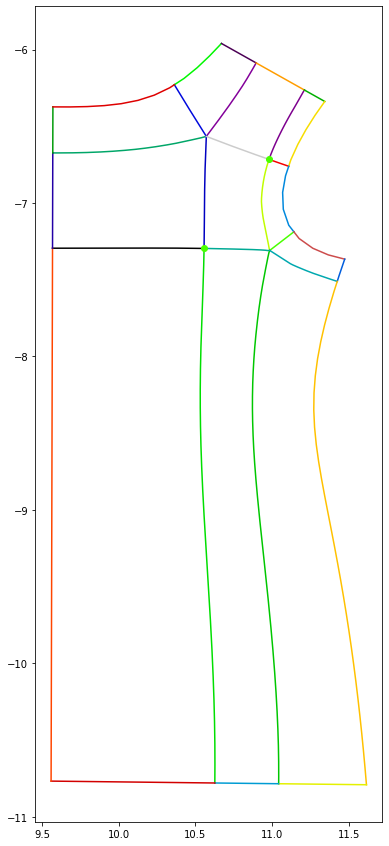

In [29]:
plt.figure(figsize=(15, 15))

import random

# tr.plot(plt.axes(), **B)
display_intrsctns = np.array(display_intrsctns)

colormap = plt.cm.nipy_spectral
colors = [colormap(i) for i in np.linspace(0, 1, len(all_stream_lines))]
random.shuffle(colors)
plt.gca().set_prop_cycle('color', colors)

for stream_line in all_stream_lines:
    plt.plot(stream_line[:,0], stream_line[:,1])

plt.plot(display_intrsctns[:,0], display_intrsctns[:,1], 'o')
    
plt.axis('scaled')

(9.402085573576628,
 11.772851929397508,
 -11.087286895567606,
 -5.670222534004477)

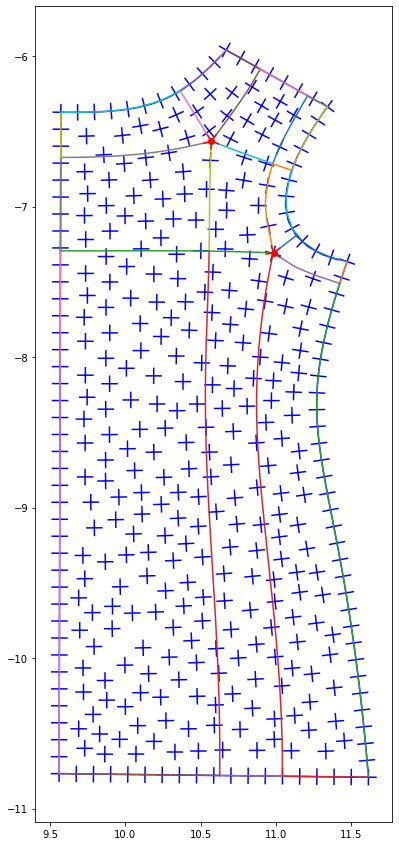

In [30]:
plt.figure(figsize=(15, 15))
    
for vid in range(N):
    plotMemCross(plt, vertices[vid], mem_as[vid])

for stream_line in all_stream_lines:
    plt.plot(stream_line[:,0], stream_line[:,1])
    
for sing in singularities:
    plt.plot(sing.loc[0], sing.loc[1], 'o', color='r')
    for i in range(len(sing.angles)):
        plotVec(plt, sing.loc, sing.angles[i], length=0.5, color='r')
plt.axis('scaled')


In [31]:
class MegaNode:
    def __init__(self, loc, out_line_ids=[], list_id = 0):
        self.loc = loc
        self.out_line_ids = out_line_ids
        self.list_id = list_id
        
mega_nodes = {}
mega_nodes_list = []
mega_map = None

def getMegaNodes():
    global mega_nodes, all_stream_lines
    for lid in range(len(all_stream_lines)):
        stream_line = all_stream_lines[lid]
        loc1 = stream_line[0]
        loc2 = stream_line[-1]
        locs = [loc1, loc2]
        for i in range(2):
            key = (locs[i][0], locs[i][1])
            if key in mega_nodes:
                mega_nodes[key].out_line_ids.append(lid)
            else:
                m_node = MegaNode(locs[i], [lid])
                mega_nodes[key] = m_node
    cur_id = 0
    for key in mega_nodes:
        mega_nodes_list.append(mega_nodes[key])
        mega_nodes[key].list_id = cur_id
        cur_id += 1

# 0 for start node, -1 for end node
def getLineNode(stream_line, which_node): 
    global mega_nodes
    return mega_nodes[(stream_line[which_node][0], stream_line[which_node][1])]

def buildMegaMap():
    global mega_nodes_list, all_stream_lines, mega_map
    
    mega_map = np.zeros([len(mega_nodes_list), len(mega_nodes_list)]) - 1
    
    for lid in range(len(all_stream_lines)):
        stream_line = all_stream_lines[lid]
        node_0 = getLineNode(stream_line, 0)
        node_1 = getLineNode(stream_line, -1)
        mega_map[node_0.list_id][node_1.list_id] = lid
        mega_map[node_1.list_id][node_0.list_id] = lid

def getOtherEnd(stream_line, m_node):
    if np.array_equal(stream_line[0], m_node.loc):
        return getLineNode(stream_line, -1)
    else:
        return getLineNode(stream_line, 0)
    
def orderOutLines():
    
    for m_node in mega_nodes_list:
        out_angles = [None] * len(m_node.out_line_ids)
        for i in range(len(m_node.out_line_ids)):
            lid = m_node.out_line_ids[i]
            othr_end = getOtherEnd(all_stream_lines[lid], m_node)
            vec = othr_end.loc - m_node.loc
            out_angles[i] = ( np.arctan2(vec[1], vec[0]), lid )
        out_angles.sort()
        for i in range(len(m_node.out_line_ids)):
             m_node.out_line_ids[i] = out_angles[i][1]
        
    
getMegaNodes()
buildMegaMap()
orderOutLines()

In [32]:
quads_line_ids = []

def getNextLineId(m_node, src_line_id):
    idx = m_node.out_line_ids.index(src_line_id)
    next_idx = (idx - 1 + len(m_node.out_line_ids)) % len(m_node.out_line_ids)
    return m_node.out_line_ids[next_idx]
            

def getUnassignedLinedId():
    global line_masks
    if not (False in line_masks):
        return -1
    return line_masks.index(False)

def whichEnd(stream_line, m_node):
    if np.array_equal(stream_line[0], m_node.loc):
        return 0
    else:
        return -1
    
def getQuadLineIds():
    global quads_line_ids
    
    # skip boundary lines
    line_masks = [None] * len(stream_lines)
    for i in range(len(stream_lines)):
        line_masks[i] = np.array([False, False])
        
    for line_id in range(len(stream_lines)):
        ends = [0, -1]
            
        # check both directions
        for i in range(2):
            if line_masks[line_id][i] == True:
                continue
                
            line_masks[line_id][i] = True
            
            end = ends[i]
            q_lids = [line_id]
            line_end_node = getLineNode(all_stream_lines[line_id], end)
            next_line_id = getNextLineId(line_end_node, line_id)

            while next_line_id != line_id:
                q_lids.append(next_line_id)
                line_end_node = getOtherEnd(all_stream_lines[next_line_id], line_end_node)

                # mark is this line is one of streamline
                if next_line_id < len(stream_lines):
                    if whichEnd(all_stream_lines[next_line_id], line_end_node) == 0:
                        line_masks[next_line_id][0] = True
                    else:
                        line_masks[next_line_id][1] = True
                    
                next_line_id = getNextLineId(line_end_node, next_line_id)


            quads_line_ids.append(q_lids)
        
        
getQuadLineIds()

In [33]:
if shape_id_test == 2:
    quads_line_ids = [[0, 1, 2, 3]]
    line_groups = [[0, 2], [1, 3]]

In [34]:
quads_line_ids

[[0, 4, 21, 20],
 [0, 19, 11, 1],
 [1, 9, 8, 2],
 [2, 13, 24, 3],
 [3, 23, 22, 4],
 [5, 9, 10, 16],
 [5, 15, 14, 6],
 [6, 29, 28, 7],
 [7, 27, 12, 8],
 [10, 11, 18, 17],
 [12, 26, 25, 13]]

In [35]:
line_groups = []

def getLineGroup():
    global line_groups, quads_line_ids
    for q_lids in quads_line_ids:
        s1 = {q_lids[0], q_lids[2]}
        s2 = {q_lids[1], q_lids[3]}

        s1_merged = False
        s2_merged = False

        for i in range(len(line_groups)):
            if len(line_groups[i].intersection(s1)) > 0:
                line_groups[i] = line_groups[i].union(s1)
                s1_merged = True

            if len(line_groups[i].intersection(s2)) > 0:
                line_groups[i] = line_groups[i].union(s2)
                s2_merged = True

        if not s1_merged:
            line_groups.append(s1)
        if not s2_merged:
            line_groups.append(s2)

getLineGroup()
line_groups

[{0, 11, 17, 21},
 {4, 20, 23},
 {1, 8, 19, 27},
 {2, 9, 16, 24},
 {3, 13, 22, 26},
 {5, 10, 14, 18},
 {6, 15, 28},
 {7, 12, 25, 29}]

# calculate streamline uv length

In [36]:
lines_uv_lens = [0] * len(all_stream_lines)
lines_lens = [0] * len(all_stream_lines)
inc_len = 0

def streamLineLength(stream_line):
    line_len = 0
    for i in range(len(stream_line)-1):
        line_len += np.linalg.norm(stream_line[i+1] - stream_line[i])
    return line_len

def getAllLinelength():
    global all_stream_lines, lines_lens, inc_len
    for i in range(len(all_stream_lines)):
        lines_lens[i] = streamLineLength(all_stream_lines[i])
    print("lines_lens: ", lines_lens)
    inc_len = min(lines_lens)
    if shape_id_test == 2:
        inc_len /= 10
        
def getAllLineUVlengths():
    global all_stream_lines, lines_lens, line_groups
    for group_lids in line_groups:
        group_line_lens = np.zeros(len(group_lids))
        group_lids_list = list(group_lids)
        for i in range(len(group_lids_list)):
            lid = group_lids_list[i]
            group_line_lens[i] = lines_lens[lid]
        avg_line_len = np.average(group_line_lens)

        inc_num = math.floor(avg_line_len / inc_len)

        for i in range(len(group_lids_list)):
            lid = group_lids_list[i]
            lines_uv_lens[lid] = inc_num
            
getAllLinelength()
getAllLineUVlengths()

lines_lens:  [0.19887680689414008, 0.6038262944472207, 0.4282740115791985, 3.491587232579725, 0.4868495222073849, 0.5789900773607503, 0.39584894695692835, 1.0094602882813097, 0.7305112216205626, 0.4352300131324505, 0.5082149849117403, 0.13596918324364765, 0.9876375061212666, 3.486504816409674, 0.40939526967011786, 0.2592086162978463, 0.3601709765632455, 0.1527331053554262, 0.48518837683665583, 0.4497340272205447, 0.3851676088084798, 0.15304848743797972, 3.3241628189920367, 0.5722033735318435, 0.4160474916416147, 1.0671305253829761, 3.473016099346238, 0.6209860843120597, 0.29998681764942725, 0.8167536225596053]


# lay vertices on streamlines

In [37]:
line_pts = [None] * len(all_stream_lines)
snd_round_vertices = []

def getLinePts():
    global line_pts, all_stream_lines, lines_uv_lens, lines_lens
    for lid in range(len(all_stream_lines)):
        stream_line = all_stream_lines[lid]
        uv_len = lines_uv_lens[lid]
        dl = lines_lens[lid] / uv_len

        line_pts[lid] = []

        # do not put vert on endpoints
        if uv_len <= 1:
            continue

        acc_len = 0
        for vid in range(len(stream_line) - 1):
            seg_len = np.linalg.norm(stream_line[vid+1] - stream_line[vid])
            acc_len += seg_len
            if acc_len >= dl:
                excess_len = acc_len - dl
                excess_t = excess_len / seg_len
                pt = excess_t * stream_line[vid] + (1 - excess_t) * stream_line[vid+1]
                line_pts[lid].append(pt)
                acc_len = excess_len
                if len(line_pts[lid]) >= uv_len - 1:
                    break
        line_pts[lid] = np.array(line_pts[lid])
        
getLinePts()

# triangulate each quad patch

(9.457085218750002, 11.71785540625, -11.032610403124998, -5.718501534374999)

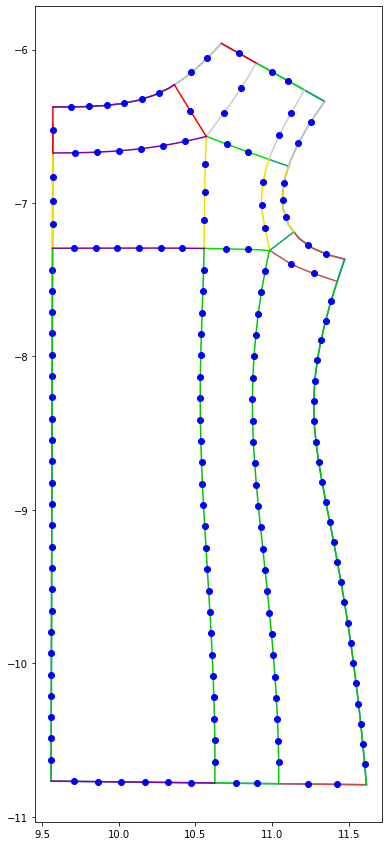

In [38]:
plt.figure(figsize=(15, 15))

shape1_verts_np = np.array(shape1_verts)
plt.plot(shape1_verts_np[:,0], shape1_verts_np[:,1])

# colors = ['r', 'g', 'b', 'y']
# colors = ['r']
# plt.gca().set_prop_cycle('color', colors)
colormap = plt.cm.nipy_spectral
colors = [colormap(i) for i in np.linspace(0, 1, len(all_stream_lines))]
random.shuffle(colors)

for gid in range(len(line_groups)):
    for lid in line_groups[gid]:
        stream_line = all_stream_lines[lid]
        plt.plot(stream_line[:,0], stream_line[:,1], color = colors[gid])

for lid in range(len(all_stream_lines)):
    if len(line_pts[lid]) > 0:
        plt.plot(line_pts[lid][:,0], line_pts[lid][:,1], 'o', color='b')
plt.axis('scaled')

In [39]:
patches_verts = []

def getCommonEndpoint(stream_line_1, stream_line_2):
    for i in [0, -1]:
        for j in [0, -1]:
            if np.array_equal(stream_line_1[i], stream_line_2[j]):
                return (stream_line_1[i], i)
            
def getPatchVerts():
    global all_stream_lines, quads_line_ids, line_pts
    for q_lids in quads_line_ids:
        patch_verts = []
        for i in range(len(q_lids)):
            lid = q_lids[i]
            next_lid = q_lids[(i+1)%len(q_lids)]
            (ep, s1_idx) = getCommonEndpoint(all_stream_lines[lid], all_stream_lines[next_lid])
            if s1_idx == -1:
                for pt in line_pts[lid]:
                    patch_verts.append(pt)
            else:
                for pt in list(reversed(line_pts[lid])):
                    patch_verts.append(pt)
            patch_verts.append(ep)
        patches_verts.append(patch_verts)
        
getPatchVerts()

In [40]:
import copy

def triangulatePatch(patch_id):
    
    segments = []
    for i in range(len(patches_verts[patch_id])-1):
        segments.append([i, i+1])
    segments.append([len(patches_verts[patch_id])-1, 0])
    
    A = dict(vertices=patches_verts[patch_id], segments=segments)
    # B = tr.triangulate(A, 'pqa.05')
    B = tr.triangulate(A, 'pqa.02')
#     tr.compare(plt, A, B)
#     plt.show()
    return B
    
def parameterizaPatch(trngl_info, patch_id):
    global line_pts, quads_line_ids
    q_lids = quads_line_ids[patch_id]
    uv_length = len(line_pts[q_lids[0]]) + 1
    uv_width = len(line_pts[q_lids[1]]) + 1
    
    uvs = []
    
    for i in range(1, uv_length+1):
        uvs.append(np.array([i, 0]))
    for i in range(1, uv_width + 1):
        uvs.append(np.array([uv_length, i]))
    for i in range(uv_length-1, -1, -1):
        uvs.append(np.array([i, uv_width]))
    for i in range(uv_width-1, -1, -1):
        uvs.append(np.array([0, i]))
    uvs = np.array(uvs)
    
    Us = harmonic_mapping.map(trngl_info['triangles'], trngl_info['vertices'], uvs[:,0])
    Vs = harmonic_mapping.map(trngl_info['triangles'], trngl_info['vertices'], uvs[:,1])
    UVs = np.stack((Us, Vs)).T
    return UVs


def parameterizeAllPatches():
    file = open("objs/patches.obj", "w")
    
    def writeOut(trngl_info, uvs, patch_id, offset):
        
        file.write("o patch_"+str(patch_id)+"\n")
        for i in range(len(trngl_info['vertices'])):
            v = trngl_info['vertices'][i]
            file.write("v " + str(v[0]) + " " + str(v[1]) + " 0.0\n")
        file.write("vn 0.0 0.0 1.0\n")
        for i in range(len(uvs)):
            uv = uvs[i]
            file.write("vt " + str(uv[0]) + " " + str(uv[1]) + "\n")
        for face in trngl_info['triangles']:
            file.write("f ")
            for i in range(3):
                file.write(str(face[i]+1+offset) + "/" + str(face[i]+1+offset) + "/" + str(patch_id+1) + " ")
            file.write("\n")
       
    offset = 0
    for patch_id in range(len(quads_line_ids)):
#     for patch_id in range(3,4):
        trngl_info = triangulatePatch(patch_id)
        uvs = parameterizaPatch(trngl_info, patch_id)
        writeOut(trngl_info, uvs, patch_id, offset)
        offset += len(trngl_info['vertices'])
        print("len(trngl_info['vertices']): ", len(trngl_info['vertices']))
#         uv_trngl_info = copy.deepcopy(trngl_info)
#         uv_trngl_info['vertices'] = uvs
#         tr.plot(plt.axes(), **uv_trngl_info)

    file.close()
        
parameterizeAllPatches()

len(trngl_info['vertices']):  8
len(trngl_info['vertices']):  10
len(trngl_info['vertices']):  17
len(trngl_info['vertices']):  82
len(trngl_info['vertices']):  93
len(trngl_info['vertices']):  14
len(trngl_info['vertices']):  12
len(trngl_info['vertices']):  22
len(trngl_info['vertices']):  36
len(trngl_info['vertices']):  8
len(trngl_info['vertices']):  171


(9.457085218750002, 11.71785540625, -11.032610403124998, -5.718501534374999)

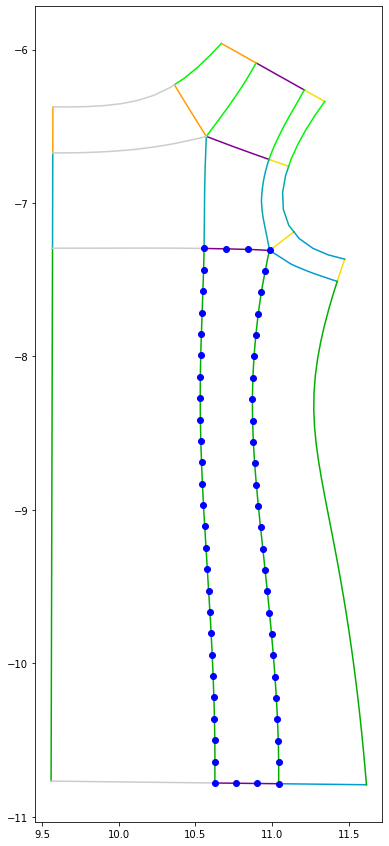

In [41]:
plt.figure(figsize=(15, 15))

colormap = plt.cm.nipy_spectral
colors = [colormap(i) for i in np.linspace(0, 1, len(all_stream_lines))]
random.shuffle(colors)

for gid in range(len(line_groups)):
    for lid in line_groups[gid]:
        stream_line = all_stream_lines[lid]
        plt.plot(stream_line[:,0], stream_line[:,1], color = colors[gid])

patch_vs_np = np.array(patches_verts[3])
plt.plot(patch_vs_np[:,0], patch_vs_np[:,1], 'o', color = 'b')
plt.axis('scaled')

In [42]:
a = {1, 2}
b = {3, 4, 1}

a = a.union(b)
a

{1, 2, 3, 4}

In [43]:
(range(10))

range(0, 10)